## Classification of 'Good / Bad' Creditors

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize
import scipy as sc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt #for plots
%matplotlib inline
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score 
import statsmodels.api as sm
from sklearn.naive_bayes import BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from itertools import combinations
import seaborn as sns

In [ ]:
# Define column names
column_names = [
    'existing_checking', 'duration', 'credit_history', 'purpose', 'credit_amount', # Explanatory Variables
    'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
    'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans',
    'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', 'foreign_worker', 
    'class'  # Target variable (1=Good, 2=Bad)
]

# Load data
df = pd.read_csv(
    'german.data-numeric',
    sep=r'\s+',
    header=None,           
    names=column_names  
)

# Convert target variable 'class' to binary (1=Good, 0=Bad)
df['class'] = df['class'].replace({1: 1, 2: 0})

In [3]:
# define data and create train test splits
n = len(df['class'])
df['x0'] = np.ones(n)
predictors = ['x0','existing_checking', 'duration', 'credit_history', 'purpose', 'credit_amount',
              'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
              'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans',
              'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone','foreign_worker']
target = ['class']
X_train, X_test, y_train, y_test = train_test_split(df[predictors], df[target],
                        test_size=0.33, random_state=42)
n,p = X_train.shape

## Plots to visualise credit risks

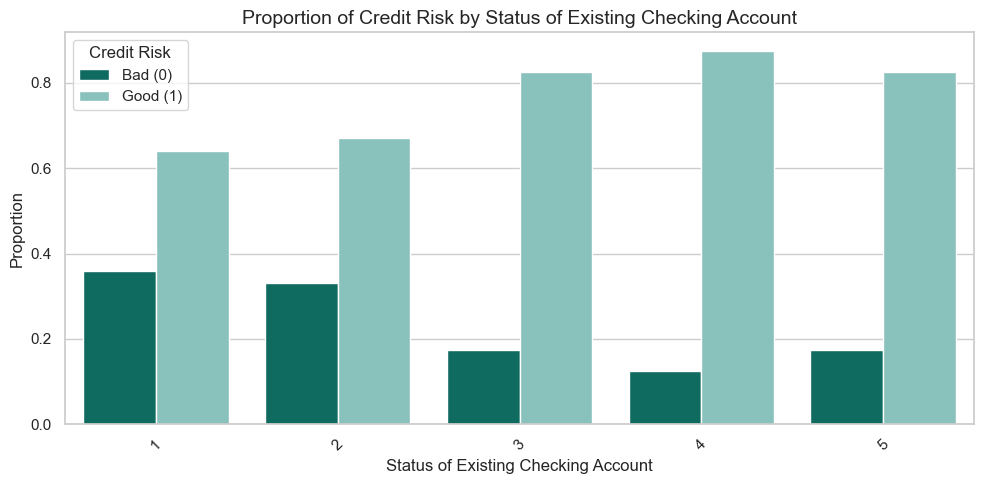

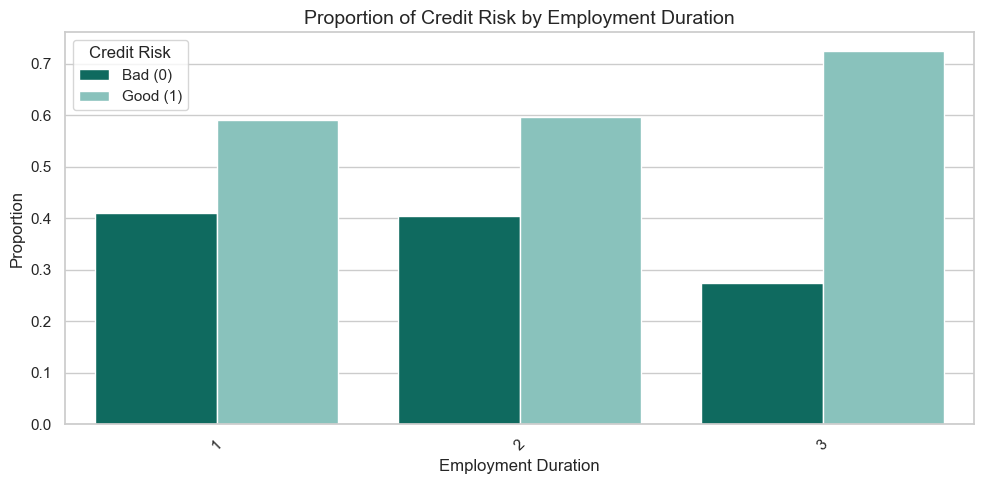

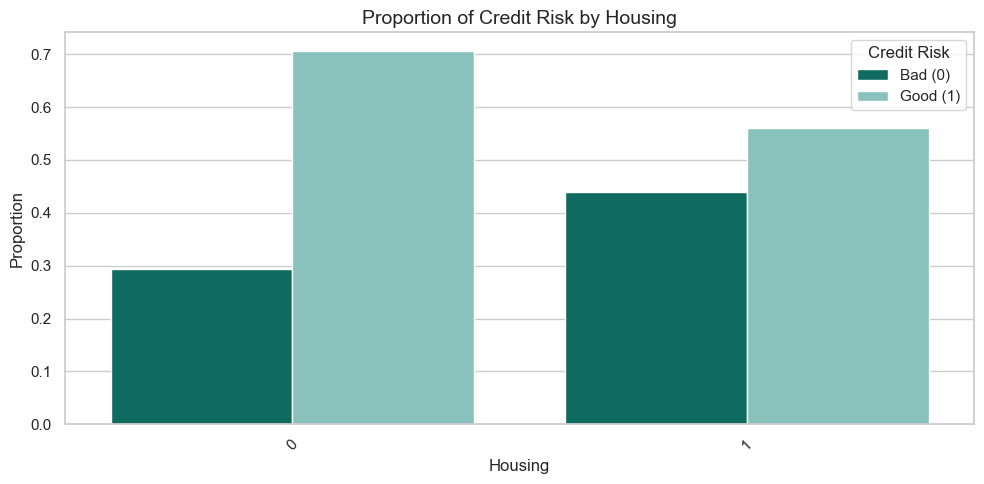

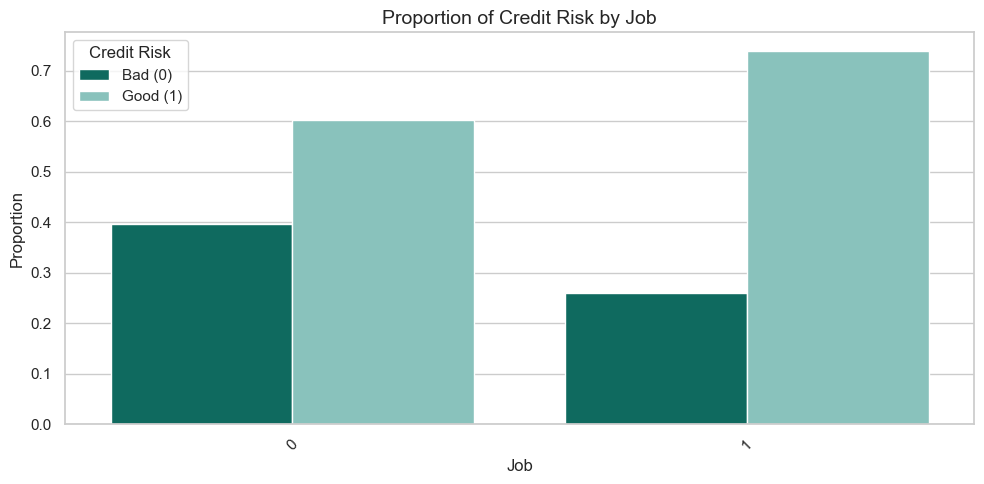

In [20]:
# Variable names to descriptive labels
variable_labels = {
    'existing_checking': 'Status of Existing Checking Account',
    'credit_history': 'Credit History',
    'purpose': 'Purpose of Loan',
    'savings_account': 'Savings Account/Bonds',
    'employment': 'Employment Duration',
    'personal_status_sex': 'Personal Status and Sex',
    'other_debtors': 'Other Debtors/Guarantors',
    'property': 'Property',
    'other_installment_plans': 'Other Installment Plans',
    'housing': 'Housing',
    'job': 'Job',
    'own_telephone': 'Own Telephone',
    'foreign_worker': 'Foreign Worker'
}

# The variables we want to plot
chosen_variables = {
    'existing_checking': 'Status of Existing Checking Account',
    'employment': 'Employment Duration',
    'housing': 'Housing',
    'job': 'Job',    
}

sns.set_theme(style="whitegrid")
teal_palette = ['#00796B', '#80CBC4']  # Dark and light teal colors

for var in chosen_variables.keys():
    # Plot proportions instead of raw counts
    counts = df.groupby([var, 'class']).size().reset_index(name='count')
    total_per_group = counts.groupby(var)['count'].transform('sum')
    counts['proportion'] = counts['count'] / total_per_group

    plt.figure(figsize=(10, 5))
    sns.barplot(data=counts, x=var, y='proportion', hue='class', palette=teal_palette)
    plt.title(f"Proportion of Credit Risk by {variable_labels[var]}", fontsize=14)
    plt.xlabel(variable_labels[var])
    plt.ylabel("Proportion")
    plt.xticks(rotation=45)
    plt.legend(title='Credit Risk')
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles, ['Bad (0)', 'Good (1)'], title='Credit Risk')
    plt.tight_layout()
    plt.show()

## Cost Matrix

|                | Predicted: Positive | Predicted: Negative |
|----------------|---------------------|---------------------|
| **Actual: Positive** | Correct Prediction = 0 units | False Negative (FN) = 1 unit |
| **Actual: Negative** | False Positive (FP) = 5 units | Correct Prediction = 0 units |


As instructed by the data source, we penalise classifying a bad risk as good five times more than classifying a good risk as bad. For this purpose, we write a function which will carry out this evaluation. 

It is important to note that this criterion means that higher accuracy is not necessarily preferable and we are more focused on reducing the false positive rate than predicting each risk accurately.

In [ ]:
def my_prediction_score(pred, test):
    """
    Scoring rule where:
    - pred=0 & test=1 adds 1 to score
    - pred=1 & test=0 adds 5 to score
    - Correct predictions add 0
    
    Returns: Final score normalized by length of test data
    """
    pred = np.array(pred).flatten()
    test = np.array(test).flatten()
    
    score = 0
    
    # Find false positives & negatives
    false_negatives = np.sum((pred == 0) & (test == 1))  # pred=0, test=1
    false_positives = np.sum((pred == 1) & (test == 0))  # pred=1, test=0
    
    score = (false_negatives * 1) + (false_positives * 5)
    
    # Normalise by number of samples
    normalised_score = score / len(test)
    
    return normalised_score # This is the error score per prediction

When approaching a classification problem, the decision threshold determines the point at which we classify an observation as positive or negative.

We are given the following cost structure:

- **False Positive Cost (FP):** 5 units  
- **False Negative Cost (FN):** 1 unit
- **Correct Prediction:** 0 units

We want to choose the threshold that **minimises the expected cost** of classification errors.

Under the assumption of equal class priors, the optimal threshold $\theta^*$ is given by:

$$
\theta^* = \frac{\text{Cost}_{\text{FN}}}{\text{Cost}_{\text{FP}} + \text{Cost}_{\text{FN}}}
$$

Substituting in the values:

$$
\theta^* = \frac{1}{5 + 1} = \frac{1}{6}
$$

Since this represents the threshold **below which we predict negative**, the optimal classification threshold for predicting the **positive class** is:

$$
1 - \theta^* = \frac{5}{6} \approx 0.833
$$

Therefore to minimize the total cost when **false positives are 5 times more expensive** than false negatives, we should only predict the positive class when the predicted probability is at least:

$$
\boxed{0.833}
$$


Training logistic regression model using maximum likelihood estimation:

In [ ]:
Xt = np.asarray(X_train[predictors])
yt = np.asarray(y_train['class'])

model = sm.Logit(yt, Xt).fit()

print("AIC:", model.aic)

model.summary()

Optimization terminated successfully.
         Current function value: 0.540151
         Iterations 6
AIC: 765.8025764934213


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  670
Model:                          Logit   Df Residuals:                      649
Method:                           MLE   Df Model:                           20
Date:                Sun, 04 May 2025   Pseudo R-squ.:                  0.1121
Time:                        14:38:36   Log-Likelihood:                -361.90
converged:                       True   LL-Null:                       -407.57
Covariance Type:            nonrobust   LLR p-value:                 4.322e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.7404      1.235     -3.029      0.002      -6.161      -1.320
x1             0.2058      0.065      3.179      0.001       0.079       0.333
x2             0.1531      0.085      1.796      0.073      -0.014       0.320
x3             0.1963      0.133      1.473      0.141      -0.065       0.457
x4            -0.0181      0.093     -0.194      0.846      -0.200       0.164
x5            -0.2603      0.110     -2.360      0.018      -0.476      -0.044
x6             0.0371      0.010      3.562      0.000       0.017       0.057
x7             0.2815      0.128      2.195      0.028       0.030       0.533
x8             0.1227      0.165      0.744      0.457      -0.200       0.446
x9            -0.2229      0.282     -0.791      0.429      -0.775       0.329
x10            0.1509      0.210      0.719      0.472      -0.260       0.562
x11            1.1529      0.647      1.781      0.075      -0.116       2.422
x12           -0.7134      0.214     -3.341      0.001      -1.132      -0.295
x13            0.6325      0.360      1.757      0.079      -0.073       1.338
x14           -0.1443      0.435     -0.332      0.740      -0.997       0.708
x15           -0.3102      0.604     -0.514      0.607      -1.493       0.873
x16            0.3599      0.400      0.899      0.368      -0.424       1.144
x17            0.8000      0.354      2.260      0.024       0.106       1.494
x18            0.4123      0.672      0.614      0.539      -0.904       1.729
x19            0.2323      0.360      0.646      0.518      -0.473       0.937
x20            0.1639      0.280      0.586      0.558      -0.384       0.712
==============================================================================
"""

Logistic regression with ridge regularisation:

In [ ]:
model_ridge = sm.Logit(yt, Xt).fit_regularized(alpha=0.92) # Regularisation parameter chosen based on AIC

print("AIC:", model_ridge.aic)

model_ridge.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5505018242454086
            Iterations: 119
            Function evaluations: 123
            Gradient evaluations: 119
AIC: 757.7669416307989


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  670
Model:                          Logit   Df Residuals:                      655
Method:                           MLE   Df Model:                           14
Date:                Sun, 04 May 2025   Pseudo R-squ.:                  0.1072
Time:                        14:38:36   Log-Likelihood:                -363.88
converged:                       True   LL-Null:                       -407.57
Covariance Type:            nonrobust   LLR p-value:                 1.187e-12
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8429      0.951     -1.938      0.053      -3.707       0.021
x1             0.2014      0.063      3.199      0.001       0.078       0.325
x2             0.1381      0.080      1.718      0.086      -0.019       0.296
x3             0.1434      0.132      1.088      0.277      -0.115       0.402
x4            -0.0215      0.091     -0.235      0.814      -0.201       0.158
x5            -0.3439      0.096     -3.564      0.000      -0.533      -0.155
x6             0.0324      0.009      3.421      0.001       0.014       0.051
x7             0.2289      0.126      1.822      0.068      -0.017       0.475
x8             0.0835      0.162      0.517      0.605      -0.233       0.400
x9            -0.1972      0.274     -0.721      0.471      -0.733       0.339
x10            0.0210      0.190      0.111      0.912      -0.351       0.393
x11            0.5105      0.539      0.947      0.344      -0.547       1.567
x12           -0.6591      0.210     -3.140      0.002      -1.070      -0.248
x13            0.5071      0.342      1.481      0.139      -0.164       1.178
x14                 0        nan        nan        nan         nan         nan
x15                 0        nan        nan        nan         nan         nan
x16                 0        nan        nan        nan         nan         nan
x17            0.4525      0.212      2.136      0.033       0.037       0.868
x18                 0        nan        nan        nan         nan         nan
x19                 0        nan        nan        nan         nan         nan
x20                 0        nan        nan        nan         nan         nan
==============================================================================
"""

Lower AIC seems to imply that regularisation has improved our model.

Next we define a function to perform stepwise logistic regression. This means we start with an empty model and then add predictors one by one if they improve our AIC. We keep adding predictors until AIC stops improving.

In [ ]:
## SOURCE: ChatGPT-4. Instructed to produce code to implement a forward stepwise logistic regression for
# statsmodels Logit() based on AIC, the LLM produced the following code:

def stepwise_logit(X, y, direction='forward'):
    initial_features = []
    remaining_features = list(X.columns)
    best_aic = np.inf
    best_model = None
    current_features = initial_features.copy()

    while remaining_features:
        aic_with_candidates = []
        for candidate in remaining_features:
            features_to_test = current_features + [candidate]
            X_train_sm = sm.add_constant(X[features_to_test])
            try:
                model = sm.Logit(y, X_train_sm).fit(disp=False)
                aic = model.aic
                aic_with_candidates.append((aic, candidate, model))
            except Exception:
                continue
        
        if not aic_with_candidates:
            break

        aic_with_candidates.sort()
        best_candidate_aic, best_candidate, best_candidate_model = aic_with_candidates[0]

        if best_candidate_aic < best_aic:
            best_aic = best_candidate_aic
            current_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_model = best_candidate_model
        else:
            break

    return best_model, current_features

In [ ]:
Xt = X_train[predictors] 
yt = y_train['class']    

model_step, selected_features = stepwise_logit(Xt, yt)
print("Selected features:", selected_features)
print(model_step.summary())
print('AIC:', model_step.aic)

Selected features: ['credit_amount', 'savings_account', 'existing_checking', 'property', 'job', 'employment', 'duration', 'present_residence', 'age']
                           Logit Regression Results                           
Dep. Variable:                  class   No. Observations:                  670
Model:                          Logit   Df Residuals:                      660
Method:                           MLE   Df Model:                            9
Date:                Sun, 04 May 2025   Pseudo R-squ.:                  0.1056
Time:                        14:38:37   Log-Likelihood:                -364.55
converged:                       True   LL-Null:                       -407.57
Covariance Type:            nonrobust   LLR p-value:                 1.008e-14
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.6979      0.906     -2

So the stepwise regression has indeed improved our AIC and left us with a more parsimonious model but we do not yet know whether it will improve predictions.

In [ ]:
threshold = 5/6 # Optimal threshold when we penalise false positives five times as much as false negatives

# Predict probabilities
logit_pred_prob = model.predict(X_test)

# Convert to class predictions (threshold=0.833)
logit_pred = np.where(logit_pred_prob >= threshold, 1, 0)

# Evaluate
print("Logistic Regression (MLE): \nAccuracy:", accuracy_score(y_test, logit_pred)) # Higher accuracy is better
print("Custom Error Score:", my_prediction_score(logit_pred,y_test)) # Lower prediction score is better

# Predict probabilities
ridge_pred_prob = model_ridge.predict(X_test)

# Convert to class predictions (threshold=0.833)
ridge_pred = np.where(ridge_pred_prob >= threshold, 1, 0)

# Evaluate
print("\nLogistic Regression (Ridge): \nAccuracy:", accuracy_score(y_test, ridge_pred)) # Higher accuracy is better
print("Custom Error Score:", my_prediction_score(ridge_pred,y_test)) # Lower prediction score is better

# Predict probabilities
X_test_with_const = sm.add_constant(X_test[selected_features], has_constant='add')
stepwise_pred_prob = model_step.predict(X_test_with_const)

# Convert to class predictions (threshold=0.833)
step_pred = np.where(stepwise_pred_prob >= threshold, 1, 0)

# Evaluate
print("\nLogistic Regression (Stepwise): \nAccuracy:", accuracy_score(y_test, step_pred)) # Higher accuracy is better
print("Custom Error Score:", my_prediction_score(step_pred,y_test)) # Lower prediction score is better

Logistic Regression (MLE): 
Accuracy: 0.4909090909090909
Custom Error Score: 0.6181818181818182

Logistic Regression (Ridge): 
Accuracy: 0.4666666666666667
Custom Error Score: 0.6545454545454545

Logistic Regression (Stepwise): 
Accuracy: 0.48787878787878786
Custom Error Score: 0.6333333333333333


So, the full logit model (although it has the worst AIC), produces the highest accuracy and the lowest error score.

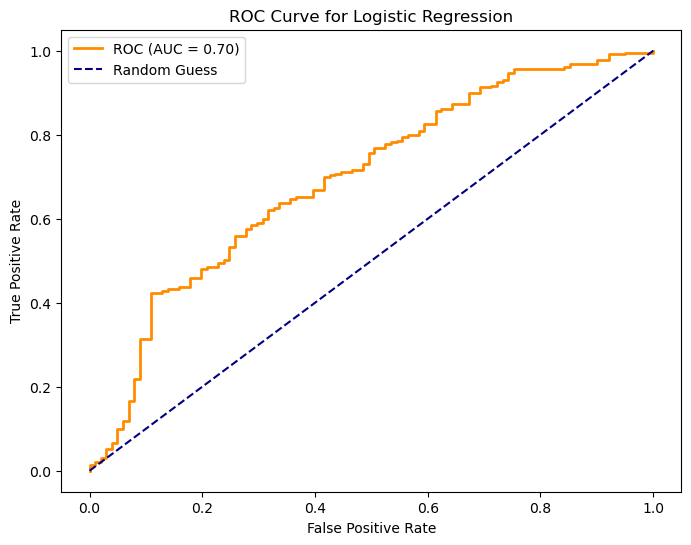

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logit_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.show()

## Bayesian Logistic Regression:

In [ ]:
## Bayesian Logistic Regression code taken from week 3 workshop:

# Sigma function is the inverse logstic function
def sigma(x,beta):
    xbeta = x.dot(beta)
    d = 1. + np.exp(-xbeta)
    return d**(-1)
# Function for negative log-likelihood of logistic regression
def nll(beta, x, y):
    t = y.T.dot(np.log(sigma(x,beta)))+ (1-y).T.dot(np.log(1.-sigma(x,beta)))
    return -t
# Functions for implementing Bayesian Logistic Regression in Python
def neg_post(beta, x, y, m0, S0):
    logprior =  - .5* (beta-m0).T @ S0 @ (beta-m0)
    return  nll(beta, x, y) -  logprior
def neg_post_prime(beta, x, y, m0, S0):
    return  x.T.dot(sigma(x,beta)-y)+S0.dot(beta-m0)
def laplace_prec(beta, x, S0):
    n = x.shape[0]  
    S = np.diag(sigma(x,beta)*(1-sigma(x,beta)))
    prec = S0.values + x.T.dot(S.dot(x))    
    return prec
def NewtonRaphsonBayesLogReg(beta0,x,y,m0,S0,maxiter,tolerance):
    i = 0
    beta = beta0
    NegLogPost = neg_post(beta, x, y, m0, S0)
    AbDiff = 1; #anything bigger than tolerance would do here
    while (AbDiff> tolerance) & (i<maxiter):
        i =i+1;
        print('iteration ',i,' Negative Log Posterior ',NegLogPost, ' AbDiff ', AbDiff)
        grad = neg_post_prime(beta, x, y, m0, S0)
        H = laplace_prec(beta, x, S0)
        H_inv = sc.linalg.inv(H) 
        beta = beta - H_inv.dot(grad)
        NegLogPost_new = neg_post(beta, x, y, m0, S0)
        AbDiff = np.abs(NegLogPost_new-NegLogPost)
        NegLogPost = NegLogPost_new
    if (iter == maxiter):
        print('Did not Converge') 
    return beta, H_inv

In [ ]:
Xt = X_train[predictors]
n,p = Xt.shape
m0 = np.zeros(p)
S0 = Xt.T.dot(Xt)/n
beta0 = np.zeros(p)
tolerance = 1e-05
maxiter = 100 
beta_map, cov = NewtonRaphsonBayesLogReg(beta0,Xt, y_train['class'],
                                                  m0,S0,maxiter,tolerance)
#95% credible intervals
se = np.sqrt(np.diag(cov))
lower95 = beta_map - 1.96*se
upper95 = beta_map + 1.96*se

#present the output via a pandas data frame
results = np.column_stack([beta_map,se,lower95,upper95])
col = ['Posterior mean','Posterior se','Lower 95% bound','Upper 95% bound']
ind = ['intercept','existing_checking', 'duration', 'credit_history', 'purpose', 'credit_amount',
       'savings_account', 'employment', 'installment_rate', 'personal_status_sex',
       'other_debtors', 'present_residence', 'property', 'age', 'other_installment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone','foreign_worker']
results = pd.DataFrame(results,columns = col,index=ind)
results

iteration  1  Negative Log Posterior  464.40861097516336  AbDiff  1
iteration  2  Negative Log Posterior  367.38389867284366  AbDiff  97.0247123023197
iteration  3  Negative Log Posterior  362.93280742985837  AbDiff  4.451091242985285
iteration  4  Negative Log Posterior  362.8389568668505  AbDiff  0.09385056300789074
iteration  5  Negative Log Posterior  362.8388833062475  AbDiff  7.356060297070144e-05


,Posterior mean,Posterior se,Lower 95% bound,Upper 95% bound
intercept,-3.673639,1.221265,-6.067318,-1.279961
existing_checking,0.202129,0.064047,0.076598,0.327661
duration,0.150982,0.084644,-0.014921,0.316885
credit_history,0.193599,0.132301,-0.065710,0.452908
purpose,-0.018166,0.092181,-0.198842,0.162510
credit_amount,-0.256215,0.109466,-0.470769,-0.041661
savings_account,0.036419,0.010298,0.016235,0.056602
employment,0.277515,0.127451,0.027712,0.527319
installment_rate,0.120656,0.163571,-0.199943,0.441256
personal_status_sex,-0.218475,0.279431,-0.766160,0.329209


In [ ]:
#Calculate the prediction probabilities with Bayesian Logistic regression
N = 10000 #number of Monte Carlo samples

# draw N samples from the approximate posterior (Laplace) of beta
betas = np.random.multivariate_normal(beta_map,cov,N)
Xbetas = X_test[predictors].dot(betas.T)
#apply sigmoid
d = 1/(1. + np.exp(-Xbetas))
pred_prob_blr = np.mean(d, axis=1)
blr_pred = (pred_prob_blr > threshold)

# Evaluate
print("Bayesian Logistic Regression: \nAccuracy:", accuracy_score(y_test, blr_pred)) # Higher accuracy is better
print("Custom Error Score:", my_prediction_score(blr_pred,y_test)) # Lower prediction score is better

Bayesian Logistic Regression: 
Accuracy: 0.47878787878787876
Custom Error Score: 0.6303030303030303


## Linear Discriminant Analysis

In [ ]:
y_tr=np.ravel(y_train)
y_te=np.ravel(y_test)
clf = LinearDiscriminantAnalysis(solver='lsqr',store_covariance=True) # Define model
clf.fit(X_train, y_tr) # Train model
clf.means_, clf.priors_, clf.covariance_

lda_pred_prob = clf.predict_proba(X_test) # Predict probabilities
lda_pred_prob = lda_pred_prob[:,1]
lda_pred = np.where(lda_pred_prob >= threshold, 1, 0)

# Evaluate
print("\nLinear Discriminant Analysis: \nAccuracy:", accuracy_score(y_test, lda_pred)) # Higher accuracy is better
print("Custom Error Score:", my_prediction_score(lda_pred,y_test)) # Lower prediction score is better


Linear Discriminant Analysis: 
Accuracy: 0.48787878787878786
Custom Error Score: 0.6212121212121212


## Naive Bayes Classifier:

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define the model
nb_model = BernoulliNB()

# Train the model
nb_model.fit(X_train, np.array(y_train).flatten())

# Make predictions
nb_pred_prob = nb_model.predict_proba(X_test)[:, 1]
nb_pred = np.where(nb_pred_prob >= threshold, 1, 0)

# Evaluate
print("Naive Bayes Classifier:\nAccuracy:", accuracy_score(y_test, nb_pred))
print("Custom Error Score:", my_prediction_score(nb_pred,y_test)) # Lower prediction score is better

Naive Bayes Classifier:
Accuracy: 0.35454545454545455
Custom Error Score: 0.6454545454545455


## Gaussian Process Classifier & Support Vector Classifier

In [ ]:
# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

# Define the kernel
kernel = 1.0**2 * RBF(length_scale=1.5) # RBF kernel

# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_standardized, np.array(y_train).flatten())

# Predict probabilities
gp_pred_probs = gp.predict_proba(X_test_standardized)[:, 1]  # Probabilities for class 1
gp_pred = np.where(gp_pred_probs >= threshold, 1, 0)
# Evaluate
print("Gaussian Proccess Classifier:\nAccuracy:", accuracy_score(y_test, gp_pred))
print("Custom Error Score:", my_prediction_score(gp_pred,y_test)) # Lower prediction score is better

Gaussian Proccess Classifier:
Accuracy: 0.30606060606060603
Custom Error Score: 0.693939393939394


In [ ]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# Create SVM model with probability support
svm_model = SVC(kernel='rbf', C=0.01, probability=True)
svm_model.fit(X_train_std, np.array(y_train).flatten())

# Get predicted probabilities
svm_pred_probs = svm_model.predict_proba(X_test_std)[:, 1]
svm_pred = np.where(svm_pred_probs >= threshold, 1, 0)
# Evaluate
print("Support Vector Classifier:\nAccuracy:", accuracy_score(y_test, svm_pred))
print("Custom Error Score:", my_prediction_score(svm_pred,y_test)) # Lower prediction score is better

Support Vector Classifier:
Accuracy: 0.30606060606060603
Custom Error Score: 0.693939393939394


Just for comparison, a dummy classifier which classifies as 'good' at the mean rate, regardless of attributes:

In [ ]:
np.mean(y_train)
dummy_pred = np.random.binomial(n=1, p=np.mean(y_train), size=330)
print("Mean Predictor:\nAccuracy:", accuracy_score(y_test, dummy_pred))
print("Custom Error Score:", my_prediction_score(dummy_pred,y_test)) # Lower prediction score is better

Mean Predictor:
Accuracy: 0.5818181818181818
Custom Error Score: 1.2666666666666666


and a classifier which classifies as 'good' at the optimal threshold rate, regardless of attributes:

In [ ]:
np.mean(y_train)
thres_pred = np.random.binomial(n=1, p=1/6, size=330)
print("Threshold Predictor:\nAccuracy:", accuracy_score(y_test, thres_pred))
print("Custom Error Score:", my_prediction_score(thres_pred,y_test)) # Lower prediction score is better

Threshold Predictor:
Accuracy: 0.38484848484848483
Custom Error Score: 0.8454545454545455


## Summary of Methods

In [ ]:
methods = [logit_pred, ridge_pred,step_pred, blr_pred, lda_pred, nb_pred, gp_pred, svm_pred, dummy_pred, thres_pred]
results = []

# Calculate the prediction score for each model
for i in range(len(methods)):
    results.append(my_prediction_score(methods[i], y_test))

# Column names (models)
col = ['Logit','Ridge','Stepwise','Bayesian Logit','LDA', 'Naive Bayes', 'GP', 'SVM', 'Mean', 'Threshold']

# Index name for error scores
ind = ['Error Score']

# Create the DataFrame with results
results_df = pd.DataFrame([results], columns=col, index=ind)

# Print the DataFrame
results_df

,Logit,Ridge,Stepwise,Bayesian Logit,LDA,Naive Bayes,GP,SVM,Mean,Threshold
Error Score,0.618182,0.654545,0.633333,0.630303,0.621212,0.645455,0.693939,0.693939,1.266667,0.845455


## Conclusion:

The best performing model was the logistic regression. Despite being one of the simplest, it held the highest prediction accuracy as well as the lowest error score at 0.618 per prediction. It was closely followed by Linear Discriminant Analysis at 0.621 error per prediction.

Notably, the mean-predictor has the highest accuracy rate at 61.8%. This is because it only tries to correctly predict the class and does not attempt to specifically reduce the false positive rate.